In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.stats import ttest_ind, ttest_1samp
import warnings
warnings.filterwarnings('ignore')

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

# despine plots by default
plt.rc("axes.spines", top=False, right=False)

#set font sizes for figures throughout
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=16)

# color palette for sequential data
palette_sqn = 'viridis_r'

# color palette for participant IDs
palette_subj = 'magma_r'

In [2]:
import data_reader
dr = data_reader.DataReader()

index = ['subj_id', 'session_no', 'block_no', 'trial_no']

exp_1, exp_2 = 'exp_1', 'exp_2'
choices_1, dynamics_1, stim_viewing_1 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_1), stim_viewing=True)
choices_2, dynamics_2, stim_viewing_2 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_2), stim_viewing=True)

First, let's take a look at hand-eye lag at initial decision (NB: we truncate distribution at 1.5 s)

ID hand-eye lag in Exp 1: -0.012s, Exp. 2: -0.024s
ID lag diff from 0, Exp. 1 p-value: 0.00000, Exp. 2: 0.00000


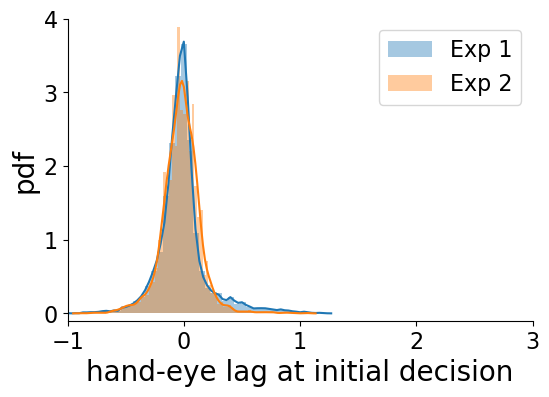

In [20]:
def ID_lag_ttest_one_sample(choices):
    t, p = ttest_1samp(choices.ID_lag[(choices.ID_lag.notnull())], 0)
    return (t, p)

def plot_ID_lag_dist(choices_1, choices_2):
    ax = sns.distplot(choices_1.loc[~np.isnan(choices_1.ID_lag), 'ID_lag'], label='Exp 1', bins=80)    
    ax = sns.distplot(choices_2.loc[~np.isnan(choices_2.ID_lag), 'ID_lag'], label='Exp 2', bins=80, ax=ax)
    ax.set_xlim((-1,3))
    ax.set_ylim((-0.1,4))
    ax.set_xlabel('hand-eye lag at initial decision')
    ax.set_ylabel('pdf')    
    plt.legend()
    plt.savefig('figures/ID_lag', bbox_inches='tight')

plot_ID_lag_dist(choices_1[(choices_1.mouse_IT<1.5)], choices_2)
print('ID hand-eye lag in Exp 1: %.3fs, Exp. 2: %.3fs' % (choices_1[(choices_1.mouse_IT<1.5)].ID_lag.mean(), 
                                                       choices_2.ID_lag.mean()))
print('ID lag diff from 0, Exp. 1 p-value: %.5f, Exp. 2: %.5f' % (ID_lag_ttest_one_sample(choices_1[(choices_1.mouse_IT<1.5)])[1], 
                                                      ID_lag_ttest_one_sample(choices_2)[1]))

Now, here is the same lag at CoM decision

CoM hand-eye lag in Exp 1: -0.034s, Exp. 2: -0.040s
CoM lag diff from 0, Exp. 1 p-value: 0.00943, Exp. 2: 0.00002


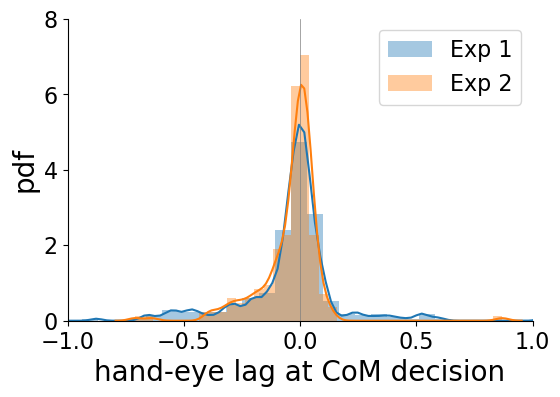

In [19]:
def com_lag_ttest_one_sample(choices):
    t, p = ttest_1samp(choices.com_lag[(choices.com_lag.notnull())], 0)
    return (t, p)

def plot_com_lag_dist(choices_1, choices_2):
    ax = sns.distplot(choices_1.loc[~np.isnan(choices_1.com_lag), 'com_lag'], label='Exp 1', bins=40)    
    ax = sns.distplot(choices_2.loc[~np.isnan(choices_2.com_lag), 'com_lag'], label='Exp 2', bins=40, ax=ax)
    ax.set_xlim((-1,1))
    ax.set_ylim((0,8))
    plt.axvline(0.0, lw=0.5, color='grey')
    ax.set_xlabel('hand-eye lag at CoM decision')
    ax.set_ylabel('pdf')    
    plt.legend()
    plt.savefig('figures/com_lag', bbox_inches='tight')

plot_com_lag_dist(choices_1, choices_2)
print('CoM hand-eye lag in Exp 1: %.3fs, Exp. 2: %.3fs' % (choices_1.com_lag.mean(), 
                                                       choices_2.com_lag.mean()))
print('CoM lag diff from 0, Exp. 1 p-value: %.5f, Exp. 2: %.5f' % (com_lag_ttest_one_sample(choices_1)[1], 
                                                      com_lag_ttest_one_sample(choices_2)[1]))


We can also look at the lags separately for early and late changes-of-mind:

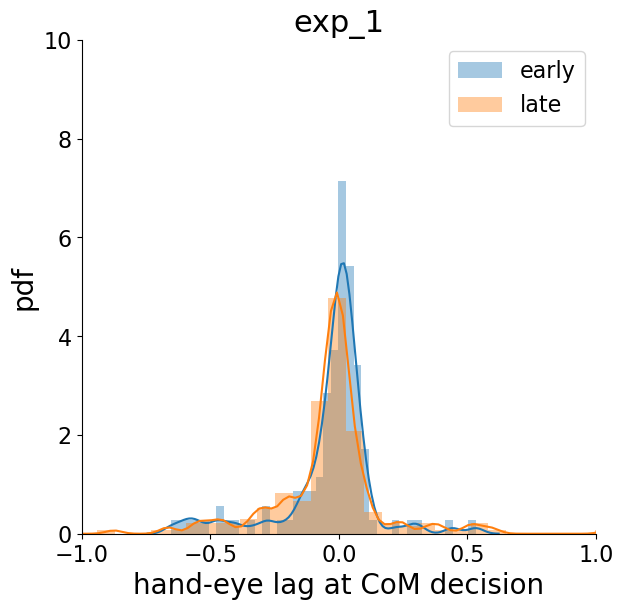

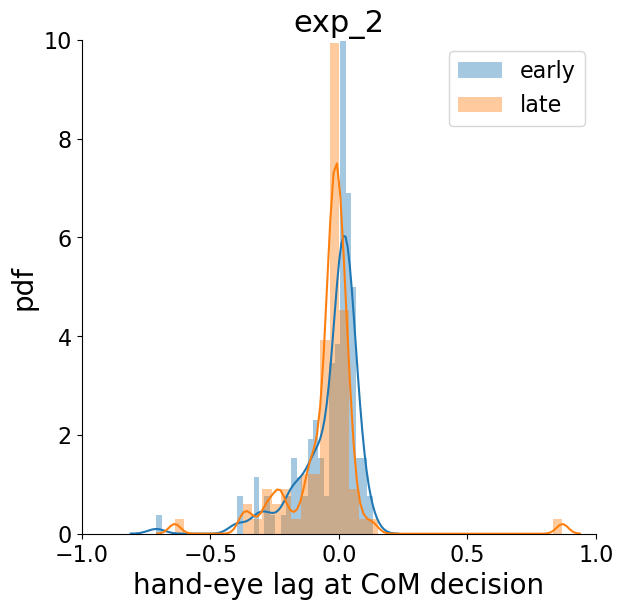

In [9]:
def plot_com_lag_dist_by_midline_d_y(choices, exp):    
#     choices['com_type'] = pd.cut(choices.midline_d_y, bins=[0, 700, 1080], labels=['early', 'late'])
    g = sns.FacetGrid(choices, hue='com_type', size=6, hue_order=['early', 'late'], xlim=(-1,1), ylim=(0,10))
    g = g.map(sns.distplot, 'com_lag', bins=40)
    g.set_axis_labels('hand-eye lag at CoM decision', 'pdf')
    plt.legend()
    plt.title(exp)
    plt.savefig('figures/com_lag_by_com_type_%s' % (exp), bbox_inches='tight')

plot_com_lag_dist_by_midline_d_y(choices_1[choices_1.is_com], exp_1)
plot_com_lag_dist_by_midline_d_y(choices_2[choices_2.is_com], exp_2)

It seems that in late CoMs, the eye lags behind the hand more than in early CoMs. The difference is not statistically significant though.

In [10]:
def pooled_sd(s1, s2):
    return np.sqrt(((len(s1)-1)*s1.var()+(len(s2)-1)*s2.var())/(len(s1)+len(s2)-2))

def com_lag_late_early_ttest(choices):
    t, p = ttest_ind(choices.loc[((choices.is_com) & (choices.com_type=='early') & (~choices.com_lag.isnull())), 'com_lag'], 
                    choices.loc[((choices.is_com) & (choices.com_type=='late') & (~choices.com_lag.isnull())), 'com_lag'], equal_var=False)
    return (t, p)

print('Exp 1, p-value: %f' % (com_lag_late_early_ttest(choices_1)[1]))
print('Exp 2, p-value: %f' % (com_lag_late_early_ttest(choices_2)[1]))


Exp 1, p-value: 0.935792
Exp 2, p-value: 0.543526
